# Parameter Optimization

Exhaustively search hyperparamters space for Support Vector Machine, AdaBoost and Logistic Regression classifiers.

### Get the data  from [property_calculations](property_calculations.ipynb) and test according to [algorithm_comparison](algorithm_comparison.ipynb)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import pickle

# Load property_array from property_calculations FEMA-JECFA database
BASE_DATA_PATH = path.join(path.expanduser('~'),
                           'Dropbox',
                           'bymt',
                           'data_dumps',
                           'chem_project')

dataset_path = path.join(BASE_DATA_PATH,
                         'property_calculations',
                         'dataset.pkl')

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)
    
train_features = dataset['train features']
train_labels = dataset['train labels']

### Hyperparameter search

In [76]:
from sklearn.preprocessing import Imputer, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline 

step_list = [('imputer', Imputer(strategy='mean')),
             ('polynomial', PolynomialFeatures(2, include_bias=False)),
             ('scaler', StandardScaler()),
             ('selector', SelectPercentile(f_classif, percentile=10)),
             ('estimator', None)]

pipe = Pipeline(step_list)

In [37]:
from sklearn.model_selection import GridSearchCV
import warnings

from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(solver='lbfgs', class_weight='balanced')
LR_params = {'estimator': [LR],
             'estimator__C': [1e-2, 1e-1, 1, 1e1, 1e2],
             'estimator__max_iter': [100, 200],
             'estimator__tol': [1e-4, 5e-4, 1e-3],
             'estimator__warm_start': [False, True]}

lr_grid = GridSearchCV(pipe,
                        param_grid=LR_params,
                        cv=4,
                        verbose=2,
                        n_jobs=-1,
                        scoring='f1_micro')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lr_grid.fit(train_features, train_labels)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=0.01 
[CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=0.01 [CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=0.01 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=0.01, total=   5.2s
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=0.01 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced'

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=0.01, total=   4.7s

[CV] estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=0.01 
[CV]  estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=0.01, total=   3.7s
[CV]  estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weigh

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=0.01 
[CV]  estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=0.01, total=   3.7s
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=0.01 
[CV]  estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.8s


[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=0.01, total=   3.6s
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=0.01 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_s

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=0.01, total=   3.0s
[CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=0.1 [CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=0.1 

[CV]  estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', d

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=0.1 

[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=0.1 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=0.1, total=   3.1s
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced',

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=0.1 
[CV]  estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=0.1, total=   3.3s
[CV] estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=0.1 
[CV]  estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=0.1, total=   4.8s
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=0.1 
[CV]  estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=0.1, total=   4.8s
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight=

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=0.1 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=0.1, total=   5.3s
[CV] estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=0.1 
[CV]  estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', du

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=1, total=   3.6s
[CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=1 
[CV]  estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=1, total=   3.7s
[CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='bala

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=1, total=   3.0s
[CV] estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=1 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=1, total=   3.2s
[CV] estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balance

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=1, total=   4.7s
[CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=1 
[CV]  estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=1, total=   7.1s
[CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='bala

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=1, total=   6.2s
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=1 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=1, total=   6.3s
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='bala

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=1, total=   5.6s
[CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=10.0 
[CV]  estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=1, total=   5.8s
[CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='bal

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=10.0 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=10.0, total=   3.2s
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=10.0 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.7min


[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=10.0, total=   3.3s
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=10.0 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_s

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=10.0 
[CV]  estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=10.0, total=   3.1s
[CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=10.0 
[CV]  estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced',

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=10.0 
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=10.0 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=10.0, total=   4.9s
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=10.0 
[CV]  estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=10.0, total=   5.0s
[CV] estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=10.0 
[CV]  estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', d

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=100.0, total=   3.5s
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=100.0 
[CV]  estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=100.0, total=   3.5s
[CV] estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_w

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=100.0 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=100, estimator__C=100.0, total=   3.4s
[CV] estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=100, estimator__C=100.0 
[CV]  estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balance

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=100.0, total=   4.9s
[CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=100.0 
[CV]  estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=100.0, total=   5.2s
[CV] estimator__tol=0.0001, estimator=LogisticRegression(C=1.0, class_

          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=100.0 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=True, estimator__max_iter=200, estimator__C=100.0, total=   5.0s
[CV] estimator__tol=0.001, estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__warm_start=False, estimator__max_iter=200, estimator__C=100.0 
[CV]  estimator__tol=0.0005, estimator=LogisticRegression(C=1.0, class_weight='balance

[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  5.6min finished


In [92]:
from sklearn.svm import SVC 

SV = SVC(random_state=42, class_weight='balanced')
SV_params = {'estimator': [SV],
             'estimator__C': [1e-2, 1e-1, 1, 1e1, 1e2],
             'estimator__kernel': ['linear', 'rbf'],
             'estimator__tol': [1e-4, 5e-4, 1e-3]}
    
sv_grid = GridSearchCV(pipe,
                       param_grid=SV_params,
                       cv=4,
                       verbose=2,
                       n_jobs=-1,
                       scoring='f1_macro')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sv_grid.fit(train_features, train_labels)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV] estimator__tol=0.0001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.01 
[CV] estimator__tol=0.0001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.01 [CV] estimator__tol=0.0001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.01 

[C

  tol=0.001, verbose=False), estimator__C=0.01 
[CV] estimator__tol=0.0001, estimator__kernel=rbf, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.01 
[CV] estimator__tol=0.0001, estimator__kernel=rbf, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.01 
[CV]  estimator__tol=0.0001, estimator__kernel=rbf, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.01, total=   9.1s
[CV] estim

  tol=0.001, verbose=False), estimator__C=0.1 
[CV]  estimator__tol=0.0001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.1, total=   5.8s
[CV] estimator__tol=0.0005, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.1 
[CV]  estimator__tol=0.0001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.1, tota

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min


[CV]  estimator__tol=0.001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.1, total=   8.3s
[CV] estimator__tol=0.0001, estimator__kernel=rbf, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.1 
[CV]  estimator__tol=0.001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.1, total=   8.3s
[CV] estimator__tol=0.0001, estimator__ker

  tol=0.001, verbose=False), estimator__C=1 
[CV]  estimator__tol=0.001, estimator__kernel=rbf, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.1, total=   7.5s
[CV] estimator__tol=0.0001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=1 
[CV]  estimator__tol=0.001, estimator__kernel=rbf, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=0.1, total=   7.2s
[C

  tol=0.001, verbose=False), estimator__C=1 
[CV]  estimator__tol=0.001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=1, total=   9.4s
[CV] estimator__tol=0.0001, estimator__kernel=rbf, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=1 
[CV]  estimator__tol=0.0001, estimator__kernel=rbf, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=1, total=  13.1s
[CV] 

  tol=0.001, verbose=False), estimator__C=10.0 
[CV]  estimator__tol=0.0001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=10.0, total=  19.1s
[CV] estimator__tol=0.0005, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=10.0 
[CV]  estimator__tol=0.0001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=10.0, 

  tol=0.001, verbose=False), estimator__C=10.0 
[CV]  estimator__tol=0.0001, estimator__kernel=rbf, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=10.0, total=   6.3s
[CV] estimator__tol=0.0005, estimator__kernel=rbf, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=10.0 
[CV]  estimator__tol=0.001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=10.0, total= 

  tol=0.001, verbose=False), estimator__C=100.0 
[CV]  estimator__tol=0.0001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=100.0, total= 2.2min
[CV] estimator__tol=0.0005, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=100.0 
[CV]  estimator__tol=0.0001, estimator__kernel=linear, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=100

  tol=0.001, verbose=False), estimator__C=100.0 
[CV]  estimator__tol=0.0005, estimator__kernel=rbf, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=100.0, total=   4.1s
[CV] estimator__tol=0.0005, estimator__kernel=rbf, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=100.0 
[CV]  estimator__tol=0.0005, estimator__kernel=rbf, estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False), estimator__C=100.0, total

[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 10.2min finished


In [39]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier(random_state=42, class_weight='balanced')
ABC = AdaBoostClassifier(base_estimator=DTC, random_state=42)
ABC_params = {'estimator': [ABC],
              'estimator__base_estimator__max_depth': [None, 3, 6, 12, 24, 48],
              'estimator__base_estimator__min_samples_leaf': [1, 2, 4, 8, 16],
              'estimator__n_estimators': [25, 50, 100, 250],
              'estimator__learning_rate': [0.01, 0.1, 1, 10]}

abc_grid = GridSearchCV(pipe,
                        param_grid=ABC_params,
                        cv=4,
                        verbose=2,
                        n_jobs=-1,
                        scoring='f1_micro')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    abc_grid.fit(train_features, train_labels)

Fitting 4 folds for each of 480 candidates, totalling 1920 fits
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impuri

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  59.7s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 4.7min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            ma

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  29.1s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.9min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 17.7min


[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  26.1s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total= 1.5min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   5.9s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=  15.0s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dep

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=  10.2s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_d

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total= 1.1min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 2.1min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            ma

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  36.2s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.6min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  23.6s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  39.0s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 3.6min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50, total=   4.7s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dep

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   5.8s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=  31.8s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 1.8min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            ma

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  33.2s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.6min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 58.3min


[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.7min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            m

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  22.0s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total= 1.4min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 3.1min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50, total=   3.8s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dep

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   5.2s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_d

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  50.7s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 1.9min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            ma

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 4.5min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.5min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  20.4s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  42.2s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 3.2min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50, total=   3.6s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dep

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 3.4min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=  22.5s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            ma

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 1.2min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  28.8s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.5min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            ma

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  18.2s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250, total= 4.8min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 3.6min
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50, total=   3.5s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   4.3s
[CV] estimator__base_estimator__max_depth=None, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=   9.2s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total=  32.5s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=   9.4s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  17.0s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250, total= 1.3min
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=Non

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 113.6min


[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  17.2s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_sample

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 1.4min
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50, total=   2.2s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 1.5min
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=Non

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=   9.5s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total=  48.9s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=   9.5s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  24.0s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250, total= 1.5min
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=Non

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  17.8s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, 

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total=  37.5s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 1.3min
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   3.1s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=   9.7s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  19.2s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 1.3min
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  17.0s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250, total= 1.3min
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=   9.1s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, 

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total=  33.7s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   2.1s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 1.5min
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=Non

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   3.8s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  16.7s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 1.4min
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  17.5s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total=  37.1s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  10.1s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, 

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total=  32.5s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   2.0s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   2.6s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   3.7s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  16.6s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dep

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 1.3min
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=   8.7s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total=  31.7s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250, total= 1.5min
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total=  32.7s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   2.1s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50, total=   2.3s
[CV] estimator__base_estimator__max_depth=3, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   3.8s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 147.2min


[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=  16.2s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_sam

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  35.4s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 2.5min
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  32.0s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250, total= 2.4min
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  18.1s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, 

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total= 1.0min
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   2.4s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   3.0s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   4.1s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  30.6s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 2.6min
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  32.4s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.1min
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  18.0s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, 

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total=  59.7s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   2.6s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   3.5s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   4.5s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  30.8s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 2.5min
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  16.0s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.0min
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250, total= 2.7min
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=Non

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total= 1.0min
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   2.4s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   2.6s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   4.1s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  30.1s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 1.1min
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  17.6s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total=  59.9s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  15.7s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, 

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  33.6s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None,

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   2.1s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 2.4min
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   3.8s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=  16.9s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total=  55.4s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 2.7min
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total=  57.5s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  15.2s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  28.3s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=Non

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   2.6s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 2.3min
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   4.3s
[CV] estimator__base_estimator__max_depth=6, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=  24.2s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 1.7min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  25.9s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  55.6s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  21.5s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  39.0s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=Non

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 3.1min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 234.4min


[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   3.4s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_sam

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 3.1min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   3.9s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=  27.9s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 1.7min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  25.3s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  50.0s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  20.7s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  39.7s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=Non

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 3.1min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50, total=   3.3s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   3.2s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=  24.4s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 1.6min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  26.2s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  55.3s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  21.2s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  40.1s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total= 1.4min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   3.1s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   3.6s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=  23.2s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  53.2s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dep

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 3.8min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  45.6s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250, total= 3.7min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250, total= 4.3min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total= 1.3min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   2.9s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   3.9s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   4.5s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  36.6s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_d

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 3.5min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  44.6s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.7min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  17.9s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total= 1.1min
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   3.5s
[CV] estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   3.4s[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=12, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   4.8s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  58.9s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dep

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 5.0min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  29.0s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.9min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  20.7s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total= 1.4min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   2.6s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   3.0s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=  10.2s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  58.7s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 2.3min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 5.8min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.9min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  21.7s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  44.6s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=Non

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 3.4min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50, total=   4.2s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   4.2s
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=  32.1s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 1.8min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  37.1s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.9min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  21.6s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  38.6s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=Non

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 377.1min


[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total= 1.3min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_sam

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   4.1s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   5.2s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   5.1s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  49.2s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dep

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 4.2min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  51.0s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.8min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250, total= 4.4min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total= 1.3min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   3.3s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   3.1s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   4.9s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  39.1s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_d

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 3.4min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 4.5min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 2.1min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  18.5s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total= 1.1min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 2.8min
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   3.3s
[CV] estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=24, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   4.8s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total= 1.1min
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 2.2min
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250, total= 5.5min
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.9min
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250, total= 4.8min
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  46.7s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=Non

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   6.2s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50, total=   5.2s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=1, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   7.9s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=  29.8s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 2.1min
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  29.9s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100, total= 1.6min
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  21.6s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  44.2s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=Non

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   3.9s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50, total=   4.3s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250, total=   5.3s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=2, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=  28.9s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 1.9min
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  30.3s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  57.3s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25, total=  22.3s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  41.5s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=Non

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250, total= 3.3min
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50, total=   2.7s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   4.2s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=4, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=  25.0s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100, total= 1.6min
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  24.8s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  45.6s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250, total= 4.0min
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=N

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  39.6s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total= 1.4min
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50, total=   2.7s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   3.8s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=8, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=25, total=  20.2s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.01, estimator__n_estimators=50, total=  44.6s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_d

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=25, total=  21.2s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=50, total=  44.8s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dep

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=0.1, estimator__n_estimators=250, total= 3.9min
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_de

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=50, total=  34.4s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=No

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=250 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=1, estimator__n_estimators=100, total= 1.2min
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=50 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=25, total=   3.0s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=

          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100 
[CV]  estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42), estimator__learning_rate=10, estimator__n_estimators=100, total=   3.7s
[CV] estimator__base_estimator__max_depth=48, estimator__base_estimator__min_samples_leaf=16, estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_dept

[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 526.4min finished


In [104]:
from sklearn.neural_network import MLPClassifier

n_features = train_features.shape[1]
n_outputs = 3

NN = MLPClassifier(random_state=42, solver='lbfgs')
NN_params = {'estimator': [NN],
             'estimator__hidden_layer_sizes': [(100,),
                                               ((n_features+n_outputs)/2,)],
             'estimator__alpha': 10.0 ** -np.arange(0, 7)}
    
nn_grid = GridSearchCV(pipe,
                       param_grid=NN_params,
                       cv=4,
                       verbose=2,
                       n_jobs=-1,
                       scoring='f1_macro')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    nn_grid.fit(train_features, train_labels)

Fitting 4 folds for each of 14 candidates, totalling 56 fits
[CV] estimator__hidden_layer_sizes=(100,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=1.0 
[CV] estimator__hidden_layer_sizes=(100,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validatio

       warm_start=False), estimator__alpha=0.1 
[CV]  estimator__hidden_layer_sizes=(81.0,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=1.0, total=  22.0s
[CV] estimator__hidden_layer_sizes=(100,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, valida

       warm_start=False), estimator__alpha=0.01 
[CV]  estimator__hidden_layer_sizes=(81.0,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=0.1, total=  21.7s
[CV] estimator__hidden_layer_sizes=(100,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, valid

       warm_start=False), estimator__alpha=0.001 
[CV]  estimator__hidden_layer_sizes=(81.0,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=0.01, total=  24.8s
[CV] estimator__hidden_layer_sizes=(100,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, val

       warm_start=False), estimator__alpha=0.0001 
[CV]  estimator__hidden_layer_sizes=(81.0,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=0.001, total=  23.0s
[CV]  estimator__hidden_layer_sizes=(81.0,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001,

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.0min


[CV]  estimator__hidden_layer_sizes=(100,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=0.0001, total=  28.9s
[CV] estimator__hidden_layer_sizes=(81.0,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm

       warm_start=False), estimator__alpha=1e-05 
[CV]  estimator__hidden_layer_sizes=(100,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=1e-05, total=  30.6s
[CV] estimator__hidden_layer_sizes=(81.0,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, va

       warm_start=False), estimator__alpha=1e-06 
[CV]  estimator__hidden_layer_sizes=(100,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), estimator__alpha=1e-06, total=  24.8s
[CV] estimator__hidden_layer_sizes=(81.0,), estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, va

[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  6.2min finished


Save the search results

In [105]:
grids = {'svc': sv_grid,
         'abc': abc_grid,
         'lr': lr_grid,
         'nn': nn_grid
        }

DATA_PATH = path.join(BASE_DATA_PATH, 'parameter_optimization')
grids_path = path.join(DATA_PATH, 'grids.pkl')

with open(grids_path, 'wb') as f:
    pickle.dump(grids, f, protocol=pickle.HIGHEST_PROTOCOL)

Compare the optimization results based on average score and t-test 95% confidence range

In [106]:
def find_top_scores(grid, class_types, cutoff=5, cv=4, verbose=False):
    """
    List the top scores from a fitted gridCV search
    
    returns list of tuples with (rank, estimator_label, test_scores, real index)
    """

    grid_results = grid.cv_results_

    score_keys = []
    end_str = '_test_score'
    start_str = 'split'
    for num in range(cv):
        complete_str = start_str+str(num)+end_str
        score_keys.append(complete_str)

    ranks = grid_results['rank_test_score']
    names_scores = []
    
    for rank in range(1,cutoff+1):
        
        idx_list = np.where(ranks == rank)[0]
        # More than one estimator can have the same rank
        for i in idx_list:
            try:
                estimator = grid_results['params'][i]['estimator']
            except KeyError:
                estimator = class_types[0][0]()
            
            for tup in class_types:
                if isinstance(estimator, tup[0]):
                    estimator_label = tup[1]
           
            test_scores = []
            for key in score_keys:
                test_scores.append(grid_results[key][i])
            
            if verbose:
                print(estimator_label)
                print(np.mean(test_scores), np.std(test_scores))
            
            names_scores.append((rank, estimator_label, test_scores, i))
    
    return names_scores

In [107]:
class_types = [(SVC, 'SVC'), (AdaBoostClassifier, 'AdaBoost'),
               (LogisticRegression, 'LR'), (MLPClassifier, 'NN')]

abc_scores = find_top_scores(grids['abc'], class_types, cutoff=10)
sv_scores = find_top_scores(grids['svc'], class_types, cutoff=10)
lr_scores = find_top_scores(grids['lr'], class_types, cutoff=10)
nn_scores = find_top_scores(grids['nn'], class_types, cutoff=10)

top_scores = [sv_scores[0], abc_scores[0], lr_scores[0], nn_scores[0]]

In [99]:
import matplotlib.patches as mpatches
import scipy.stats as st

def t_delta(percent, scores):
    """
    Returns the size of a t-test error bar that defines a given percent confidence interval 
    """
    mean, sem = np.mean(scores), st.sem(scores)
    interval = st.t.interval(percent/float(100), len(scores)-1, loc=mean, scale=sem)
    delta = mean - interval[0]
    return delta


def plot_scores(score_list):
    """
    plots scores from score_list generated by find_top_scores
    
    score_list should be a list of tuples in the form:
    tup[0] = rank
    tup[1] = estimator label string
    tup[2] = list of scores
    tup[3] = real_index
    """
    
    ranks = [tup[0] for tup in score_list]
    labels = [tup[1] for tup in score_list]
    scores = [tup[2] for tup in score_list]
    means = [np.mean(x) for x in scores]
    deltas = [t_delta(95, x) for x in scores]
    
    plt.close('all')
    ind = len(score_list)
    fig = plt.figure(1, figsize=(8, 6), tight_layout=True)
    ax = fig.gca(title='Top optimized estimator scores',
                 xlabel='Rank',
                 xlim=[-1, ind],
                 xticks=range(ind),
                 ylabel='average score')
    bar_list = ax.bar(range(ind), means, yerr=deltas, align='center')
    ax.set_xticklabels(ranks)
    # color bar based on label selected features red
    color_dict = {'AdaBoost': 'b',
                  'SVC': 'g',
                  'LR': 'm', 
                  'NN': 'r'}
    for i, name in enumerate(labels):
        bar_list[i].set_color(color_dict[name])
        
    # create custom legend
    blue_patch = mpatches.Patch(color='blue', label='Adaboost')
    green_patch = mpatches.Patch(color='green', label='SVC')
    magenta_patch = mpatches.Patch(color='magenta', label='LR')
    red_patch = mpatches.Patch(color='red', label='NN')
    plt.legend(handles=[green_patch, blue_patch, magenta_patch, red_patch])
    plt.show()

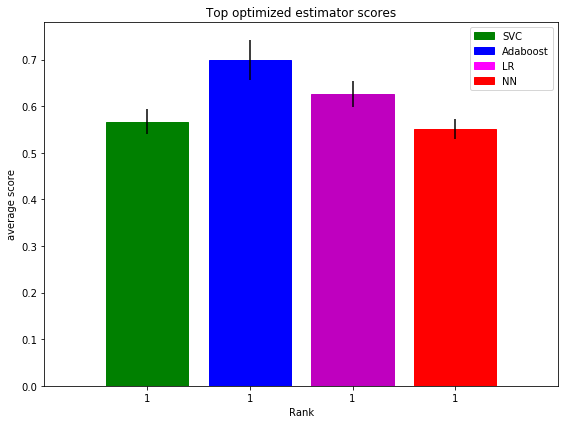

In [108]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_scores(top_scores)

In [111]:
from sklearn.metrics import classification_report

best = abc_grid.best_estimator_
pred = best.predict(dataset['test features'])
print(classification_report(y_pred=pred, y_true=dataset['test labels']))

             precision    recall  f1-score   support

        0.0       0.67      0.91      0.77       407
        1.0       0.60      0.18      0.28        98
        2.0       0.58      0.26      0.36       146

avg / total       0.64      0.66      0.60       651

